# Choosing the distance thresholds for tracking
The search radius parameterization aims to minimize the number of potential matches by limiting the search window. This should be done based on the physics of sea ice. Alan’s work on the meander coefficient is a great starting point for this. The question is: after an elapsed time oft, how large should the search window be so that we have high confidence that the true floe position will be within the window?

We estimate this from buoy trajectories. We'll estimate the travel distance at 30 min, 1 hr, 90 min, 1 day, 2 day, up to 5 days. 

The processing code is built off of Alan's work from last term. In turn, he adapted code I'd written for the MOSAiC processing. Here, I'll be returning to this code and fixing it so that fewer buoys are rejected. Currently many years have no buoys pass QC.

In [124]:
import os
import pandas as pd
import sys
sys.path.append('../utils/')
import process_position

In [128]:
overwrite = True
show_progress = True
data_loc = '../data/iabp/raw/'
save_loc = '../data/iabp/clean/'

level_one_file_list = [f for f in os.listdir(data_loc) if f[0] != '.']
level_one_file_list.sort()

for f in level_one_file_list:
    year = f.split('_')[1].replace('.csv', '')
    if "2023" not in str(f):
        minute_label = "Minute"
        second_label = "Second"
    else:
        minute_label = "Min"
        second_label = "Sec"

    l1_year = pd.read_csv(data_loc + f, usecols = ["BuoyID", "Lat", "Lon", "Year", "Month", "Day", "Hour", minute_label, second_label])
    l1_year = l1_year.rename(columns = {minute_label:"Minute", second_label:"Second", "Lat": "latitude", "Lon": "longitude"})
    l1_year["timestamp"] = pd.to_datetime(l1_year[["Year", "Month", "Day", "Hour", "Minute", "Second"]])
    l1_year = l1_year.set_index("timestamp")

    l1_year = l1_year.drop(columns=["Year", "Month", "Day", "Hour", "Minute", "Second"])
    
    groups = l1_year.groupby("BuoyID")
    total_buoys = len(groups)
    buoys_complete = 0

    for buoy, data in groups:
        if int(buoy) < 10**6:
            continue

        if not overwrite and f"{buoy}.csv" in os.listdir("{s}/{y}/{buoy}.csv".format(buoy=buoy, s=save_loc, y=year)):
           continue

        clean = process_position.clean_location_df(data)

        if clean is not None:
           clean.to_csv("{s}/{y}/{buoy}.csv".format(buoy=buoy, s=save_loc, y=year))

        if show_progress:
            buoys_complete += 1
            sys.stdout.write('\r')
            count = buoys_complete / total_buoys
            sys.stdout.write("[%-100s] %d%%" % ('='*int(100*count), int(100/total_buoys*buoys_complete)))
            sys.stdout.flush()
    print(f)

LEVEL1_2002.csv
LEVEL1_2003.csv
LEVEL1_2004.csv
LEVEL1_2005.csv
LEVEL1_2006.csv
LEVEL1_2007.csv
LEVEL1_2008.csv
[======                                                                                              ] 6%LEVEL1_2009.csv
[======================                                                                              ] 22%LEVEL1_2010.csv
[==============================================                                                      ] 46%LEVEL1_2011.csv
[==============================================================                                      ] 62%LEVEL1_2012.csv
[===========================================================                                         ] 59%LEVEL1_2013.csv
[=========================================================                                           ] 57%LEVEL1_2014.csv
[=================================================================                                   ] 65%LEVEL1_2015.csv
[==================================

In [126]:

freq = process_position.get_frequency(l1_year)
freq

'30min'

In [127]:
groups = l1_year.groupby("BuoyID")
for buoy, data in groups:
    break
data

,BuoyID,latitude,longitude
timestamp,,,
2002-04-29 05:21:16,800001,88.51433,71.60488
2002-04-29 08:20:48,800001,88.51649,71.62408
2002-04-29 11:21:12,800001,88.51806,71.52206
2002-04-29 14:21:16,800001,88.51906,71.38735
2002-04-29 17:21:10,800001,88.51961,71.30231
...,...,...,...
2002-12-31 18:57:24,800001,84.00097,25.91170
2002-12-31 19:12:25,800001,84.00144,25.91780
2002-12-31 21:42:07,800001,84.00643,25.98063


In [129]:
import proplot as pplt
buoy_data = {}
for year in range(2003, 2022):
    files = os.listdir(save_loc + str(year))
    print(year, len(files))
    if len(files) > 0:
        buoy_data[year] = {}
        for f in files:
            if '.' != f[0]:
                buoy_data[year][f.replace('.csv', '')] = pd.read_csv(save_loc + str(year) + '/' + f, parse_dates=True)

2003 0
2004 0
2005 0
2006 0
2007 0
2008 0
2009 1
2010 3
2011 16
2012 23
2013 27
2014 54
2015 102
2016 98
2017 0
2018 0
2019 0
2020 0
2021 0


/Users/dmw/miniconda3/envs/airsea/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


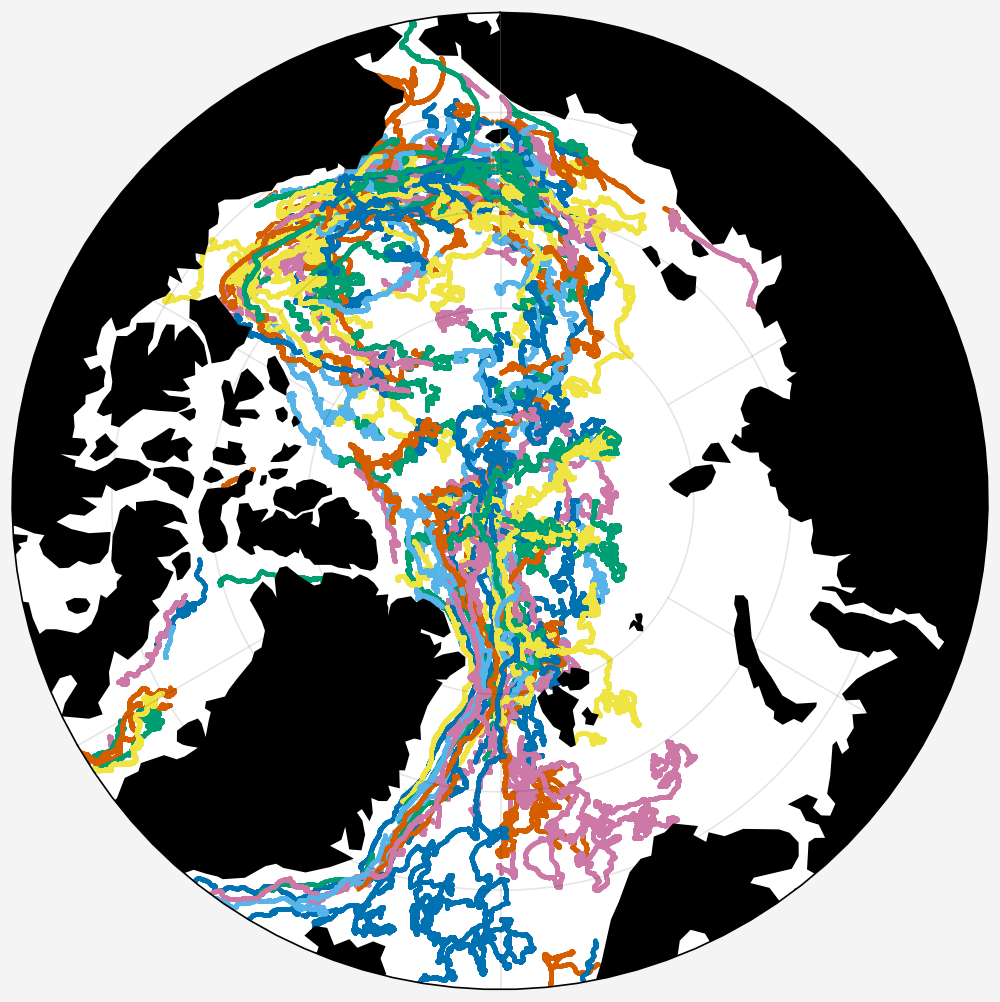

In [130]:
fig, ax = pplt.subplots(proj='npstere', width=5)
ax.format(boundinglat=65, land=True)
for year in buoy_data:
    for buoy in buoy_data[year]:
        ax.scatter(buoy_data[year][buoy].longitude,
                buoy_data[year][buoy].latitude, ms=1)
                

# Finalizing quality control
The quality control isn't perfect, however we should be able to get the worst offenders out. There are a few, like the zigzag through the Fram Strait, that might need manual intervention. The next steps are
1. Select only data that is within the sea-ice covered region. Method: NSIDC CDR SIC Monthly Average needs to be above 0.15 and not in the coastal mask.
2. Division of data into regions: Central Arctic, some number of sectors. Check number of data points in each.
3. Calculate distribution of distances by year.

In [146]:
import xarray as xr
files = [f for f in os.listdir('../data/nsidc_sic/') if '.nc' in f]
files.sort()
for year in range(2002, 2023):
    ds_year = []
    fyear = [f for f in files if '_' + str(year) in f]
    for f in fyear:
        with xr.open_dataset('../data/nsidc_sic/' + f) as ds:
            ds_year.append(ds.load())
    xr.concat(ds_year, dim='time').to_netcdf('../data/nsidc_agg/nsidc_cdr_sic_' + str(year) + '.nc',
                                         encoding = {var:
                                {"zlib": True, "complevel": 9} for var in
                                                     ['cdr_seaice_conc_monthly',
                                                      'cdr_seaice_conc_monthly_stdev',
                                                      'cdr_seaice_conc_monthly_qa_flag']})

In [145]:
! mkdir '../data/nsidc_agg/'
xr.concat(ds_year, dim='time').to_netcdf('../data/nsidc_agg/nsidc_cdr_sic_' + str(year) + '.nc',
                                         encoding = {var:
                                {"zlib": True, "complevel": 9} for var in ['cdr_seaice_conc_monthly', 'cdr_seaice_conc_monthly_stdev', 'cdr_seaice_conc_monthly_qa_flag']})

In [138]:
import pyproj
g = pyproj.Geod(ellps='WGS84')
"/Users/dmw/Documents/Research/ift_calibration/data/nsidc_sic"
data_loc


'../data/iabp/raw/'

In [98]:
buoy_data[year].keys()

dict_keys(['300234010085650', '300025010128510', '300025010125530'])

In [103]:
buoy= '300025010128510'
df = buoy_data[year][buoy]
df['datetime'] = pd.to_datetime(df['datetime'].values)

df = df.set_index('datetime')

df_daily = df.resample('1d').asfreq()
df_hourly = df.resample('1h').asfreq()
import numpy as np
np.quantile(dist[~np.isnan(dist)], 0.9)

44784.79490239945

In [104]:
results = []
for hours in (1, 3, 6, 12, 24, 48):
    df_samp = df.resample('{t}h'.format(t=hours)).asfreq()
    fwd, bck, dist = g.inv(df_samp.longitude, df_samp.latitude, df_samp.shift(1).longitude, df_samp.shift(1).latitude)
    dist = dist[~np.isnan(dist)]
    print(hours, len(dist))
    results.append([np.median(dist), np.mean(dist), np.quantile(dist, 0.75), np.quantile(dist, 0.99)])

1 361
3 120
6 60
12 30
24 15
48 7


In [105]:
results = pd.DataFrame(results, columns=['median', 'mean', 'q75', 'q99'], index=[1, 3, 6, 12, 24, 48])
results

,median,mean,q75,q99
1,649.047774,642.842161,888.095824,1428.797298
3,1954.611671,1923.599039,2632.810583,4155.099830
6,3828.372290,3820.604741,5035.014601,8117.240555
12,7496.249327,7588.694390,9823.542742,15428.384426
24,15461.591732,14989.390674,18377.507639,29005.694277
48,35369.208446,29631.786754,39817.261817,46122.594748


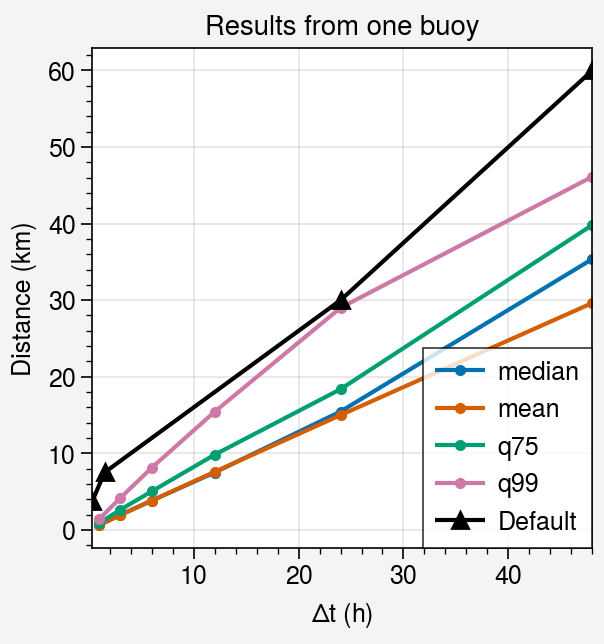

In [107]:
results = pd.DataFrame(results, columns=['median', 'mean', 'q75', 'q99'], index=[1, 3, 6, 12, 24, 48])
fig, ax = pplt.subplots()
ax.plot(results/1e3, marker='.')
ax.plot([1/3, 1.5, 24, 48], [3.75, 7.5, 30, 60], color='k', m='^', label='Default')
ax.legend(loc='lr', ncols=1)
ax.format(ylabel='Distance (km)', xlabel='$\Delta t$ (h)')

ax.format(yscale='linear', title='Results from one buoy')